In [1]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

''' 
This program merges all of the separate programs (protagonists.ipynb and synopsis.ipynb) and adds the text search function. It will
return all of the movies that contain family keywords inside a data frame. This program runs in approximately 7-8 mins."
'''

def movie_table(url):
    webpage = url
    response = requests.get(webpage)

    page = response.text

    soup = BeautifulSoup(page, 'html.parser')
    beautiful_page = soup.get_text()

    ratings = []
    years = []
    titles = []
    movie_nums = []

    lines = beautiful_page.splitlines()

    for line in lines:
        if "(20" in line and ")" in line or '(19' in line and ')' in line:
            years.append(line)

    rep_years = []
    nrep_years = []
    year_indices = []

    for year in years:
        
        if lines.count(year) > 1:
            if year not in rep_years:
                rep_years.append(year)
        if lines.count(year) == 1:
            nrep_years.append(year)

    for i in range(len(rep_years)):
        first_instance = lines.index(rep_years[i])
        year_indices.append(first_instance)

        for j, item in enumerate(lines[first_instance+1:], start=first_instance+1):
            if item == rep_years[i]:
                year_indices.append(j)

    for year in nrep_years:
        if year in lines:
            index = lines.index(year)
            year_indices.append(index)


    for index in sorted(year_indices):
        title = lines[index-1]
        titles.append(title)

        rating = lines[index+6]
        ratings.append(rating)

        movie_num = lines[index-3]
        movie_nums.append(movie_num) 
        

    ratings = [rating.lstrip() for rating in ratings]
    for i in range(len(ratings)):
        if ratings[i] == '':
            ratings[i] = "None"


    for i in range(len(years)):
        for j in range(len(years[i])):
            if years[i][j].isnumeric():
                number_index = years[i].find(years[i][j])
                years[i] = years[i][number_index:number_index+4]
                break


    table_data = list(zip(movie_nums, titles, years, ratings))
    # headers = ["Movie Number", "Title", "Year", "Rating"]

    # print(tabulate(table_data, headers=headers))
    
    return table_data

synopsis_list = []

# Function to get the synopsis from every movie in the webpage
def synopses(link):
    webpage = link
    response = requests.get(webpage)

    page = response.text

    soup = BeautifulSoup(page, 'html.parser')

    url_list = []
    movie_url_list = []
    movie_ref_nums = []

    # Get all the hyperlinks
    for link in soup.find_all('a'):
        url_list.append(link.get('href'))

    # Filter to get movie title hyperlinks
    for url in url_list:
        if '/title/tt' in url:
            if url not in movie_url_list:
                movie_url_list.append(url) 

    # Take the reference number from the movie url
    for movie_url in movie_url_list:
        movie_ref_nums.append(movie_url[7:16])


    # Extract the synopsis from every movie then append to a list
    driver = webdriver.Chrome('/Users/nixoncarino/Desktop/chromedriver')

    for i in movie_ref_nums:
        url = "https://www.imdb.com/title/" + i + "/plotsummary/?ref_=tt_stry_pl#synopsis"
        try:
            driver.get(url)
            synopsis_element = driver.find_element(By.XPATH, '//*[@id="__next"]/main/div/section/div/section/div/div[1]/section[2]/div[2]/ul/li/div/div/div/div/div')
        except:
            synopsis_list.append("No Synopsis")
        else:
            synopsis = synopsis_element.text
            synopsis_list.append(synopsis)

# Function that find family related words on the synopsis
def text_search(synopsis_list):
    # The indices of the synopses that contain any of the keywords
    match_index_list = []

    keywords = ["family", "parenting", "father", "mother", "son", "daughter", "sibling", "brother", "sister", "marriage", "divorce", "blended family", "adoption",
                "foster care", "custody", "inheritance", "legacy", "generations", "multigenerational", "family reunion", "family secrets", "family drama", "dysfunctional", 
                "dysfunctional family", "family conflict", "family relationships", "family values", "family ties", "parent-child relationship", "relationship",
                "coming-of-age", "parenthood", "growing up", "childhood", "teenage years", "aging parents", "grandparents"]

    for i in range(len(synopsis_list)):
        for keyword in keywords:
            if keyword in synopsis_list[i]:
                if i not in match_index_list:
                    match_index_list.append(i)

    return match_index_list

def non_family_movies(synopsis_list):
    all_indices = list(range(0,len(synopsis_list)))

    # The indices of the synopses that contain any of the keywords
    match_index_list = []

    keywords = ["family", "parenting", "father", "mother", "son", "daughter", "sibling", "brother", "sister", "marriage", "divorce", "blended family", "adoption",
                "foster care", "custody", "inheritance", "legacy", "generations", "multigenerational", "family reunion", "family secrets", "family drama", "dysfunctional", 
                "dysfunctional family", "family conflict", "family relationships", "family values", "family ties", "parent-child relationship", "relationship",
                "coming-of-age", "parenthood", "growing up", "childhood", "teenage years", "aging parents", "grandparents"]

    for i in range(len(synopsis_list)):
        for keyword in keywords:
            if keyword in synopsis_list[i]:
                if i not in match_index_list:
                    match_index_list.append(i)
    
    non_match_index = [index for index in all_indices if index not in match_index_list]

    return non_match_index

# Call synopses function to put all synopses into list
synopses("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=horror&view=simple")
synopses("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=horror&view=simple&start=51&ref_=adv_nxt")

# Create Data Frame for Movie information
df_horror_1 = pd.DataFrame(movie_table("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=horror&view=simple"), 
                            columns=['Index', 'Title', 'Year', 'Rating'])
df_horror_2 = pd.DataFrame(movie_table("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=horror&view=simple&start=51&ref_=adv_nxt"), 
                            columns=['Index', 'Title', 'Year', 'Rating'])
df_horror = pd.concat([df_horror_1, df_horror_2], ignore_index=True).assign(Genre='Horror', Synopsis=synopsis_list)

# Output information of movies that contain family keywords
pd.set_option('display.max_rows', None)
full_horror = df_horror.iloc[text_search(synopsis_list)]
full_horror


/var/folders/_2/zj00cgg95ts6m3mqz4zzzxym0000gn/T/ipykernel_15568/950189021.py:122: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/nixoncarino/Desktop/chromedriver')


,Index,Title,Year,Rating,Genre,Synopsis
5,6.,The Menu,2022,7.2,Horror,Margot Mills and her date Tyler travel by boat...
6,7.,Evil Dead,2013,6.5,Horror,The film starts with a young woman walking thr...
8,9.,Midsommar,2019,7.1,Horror,"The film opens with a mural of a bizarre, eeri..."
11,12.,The Meg,2018,5.6,Horror,"In the opening scene, Jonas Taylor (Jason Stat..."
12,13.,M3GAN,2022,6.4,Horror,"The film starts with a commercial for ""Purrpet..."
14,15.,Hereditary,2018,7.3,Horror,The story begins with the viewer looking out f...
15,16.,The Evil Dead,1981,7.4,Horror,Five Michigan State University students ventur...
16,17.,American Psycho,2000,7.6,Horror,A white background. Red drops begin to fall pa...
19,20.,Scream,1996,7.4,Horror,The film opens with young Casey Becker (Drew B...
21,22.,Mother!,2017,6.6,Horror,Note: the characters in this film are unnamed ...


/var/folders/_2/zj00cgg95ts6m3mqz4zzzxym0000gn/T/ipykernel_15568/770584081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_horror['Chronological Year'] = full_horror_sorted['Year'].values


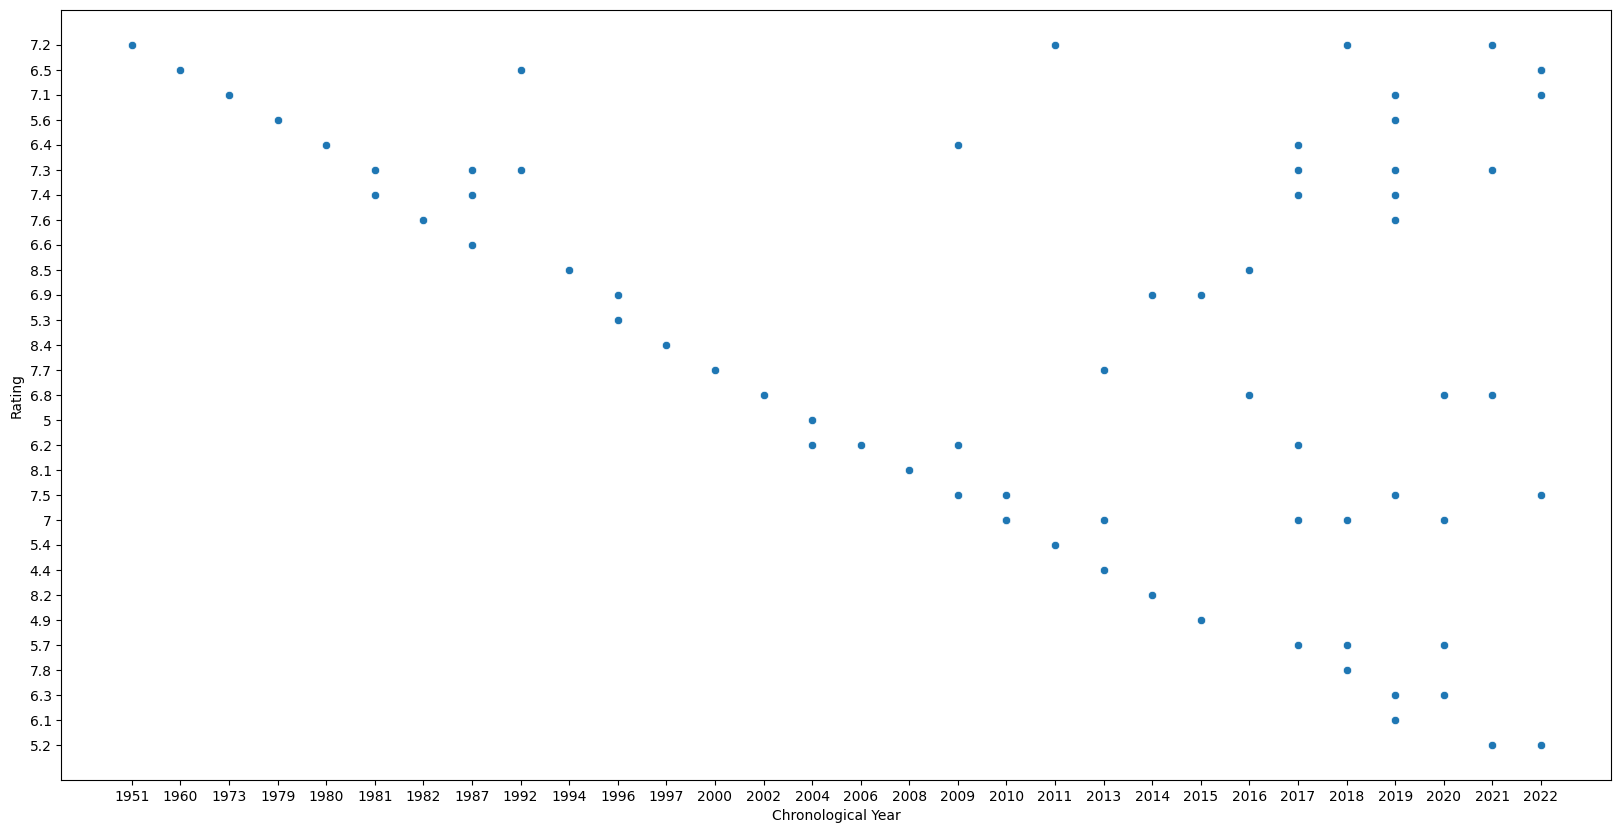

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
isinstance(full_horror, pd.DataFrame)
full_horror_sorted = full_horror.sort_values('Year')
full_horror['Chronological Year'] = full_horror_sorted['Year'].values
plt.figure(figsize=(20, 10))
sns.scatterplot(x='Chronological Year', y='Rating', data=full_horror)
plt.show()


In [2]:
non_family = df_horror.iloc[non_family_movies(synopsis_list)]; non_family

,Index,Title,Year,Rating,Genre,Synopsis
0,1.,Evil Dead Rise,2023,6.8,Horror,No Synopsis
1,2.,The Pope's Exorcist,2023,6.1,Horror,No Synopsis
2,3.,Scream VI,2023,6.7,Horror,No Synopsis
3,4.,Renfield,2023,6.4,Horror,No Synopsis
4,5.,X,2022,6.6,Horror,No Synopsis
7,8.,Knock at the Cabin,2023,6.1,Horror,No Synopsis
9,10.,Pearl,2022,7,Horror,No Synopsis
10,11.,Scream,2022,6.3,Horror,No Synopsis
13,14.,Nope,2022,6.8,Horror,No Synopsis
17,18.,Infinity Pool,2023,6.1,Horror,No Synopsis


In [16]:
print(full_horror["Rating"])
print(full_horror['Year'])

correlation()




5     7.2
6     6.5
8     7.1
11    5.6
12    6.4
14    7.3
15    7.4
16    7.6
19    7.4
21    6.6
22    7.3
25    6.5
26    7.3
27    8.5
29    6.9
30    5.3
31    8.4
32    7.7
33    6.8
34      5
35    6.2
36    6.2
37    8.1
39    6.2
41    6.4
42    7.5
43    7.5
44      7
45      7
46    7.2
47    5.4
48    7.7
49    4.4
50      7
51    6.9
52    8.2
54    6.9
55    4.9
56    8.5
58    6.8
59    7.3
60    6.4
61    7.4
63    5.7
64    6.2
65      7
68    7.2
69    5.7
70    7.8
71      7
72    7.1
74    6.3
75    6.1
76    7.5
77    7.4
78    7.3
79    7.6
80    5.6
81    6.8
82    5.7
83    6.3
84      7
85    7.2
88    6.8
89    5.2
91    7.3
92    6.5
94    5.2
96    7.1
98    6.5
99    7.5
Name: Rating, dtype: object
5     2022
6     2013
8     2019
11    2018
12    2022
14    2018
15    1981
16    2000
19    1996
21    2017
22    2004
25    2020
26    2017
27    1979
29    2022
30    2014
31    1980
32    2017
33    2019
34    2010
35    2019
36    2010
37    1973
39    201